In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook,trange

import torch
from torch.nn import Parameter
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam

In [2]:
torch.__version__

'0.4.1'

In [3]:
# Transformer function for image preprocessing
transforms_func = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# mnist train_set
mnist_train = MNIST('./data',train=True,download=True,transform=transforms_func)

# mnist test_set
mnist_test = MNIST('./data',train=False,transform=transforms_func)

In [4]:
train_len = int(0.9*mnist_train.__len__())
valid_len = mnist_train.__len__() - train_len
mnist_train, mnist_valid = torch.utils.data.random_split(mnist_train, lengths=[train_len, valid_len])

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(mnist_train.__len__()))
print("- Validation-set:\t{}".format(mnist_valid.__len__()))
print("- Test-set:\t\t{}".format(mnist_test.__len__()))

Size of:
- Training-set:		54000
- Validation-set:	6000
- Test-set:		10000


In [6]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [7]:
# The number of pixels in each dimension of an image.
img_size = (28,28)

# The images are stored in one-dimensional arrays of this length.
img_size_flat = 784

# Tuple with height and width of images used to reshape arrays.
img_shape = (28,28)

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

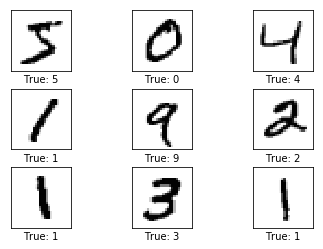

In [9]:
# Get the first images from the test-set.
images = mnist_train.dataset.train_data[0:9]

# Get the true classes for those images.
cls_true = mnist_train.dataset.train_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(5,5),stride=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=(5,5),stride=1)
        self.fc1 = nn.Linear(in_features=576,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=10)
    
    def forward(self,x):
        out = F.relu(F.max_pool2d(self.conv1(x),kernel_size=(2,2)))
        out = F.relu(F.max_pool2d(self.conv2(out),kernel_size=(2,2)))
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = F.log_softmax(self.fc2(out))
        return out

In [19]:
def train(model,device,train_loader,optimizer):
    model.train()
    correct = 0
    for data,target in tqdm_notebook(train_loader,total=train_loader.__len__()):
        #data = torch.reshape(data,(-1,784))
        import pdb;pdb.set_trace()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(train_loader.dataset),100. * correct / len(train_loader.dataset)))

In [12]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i,(data, target) in tqdm_notebook(enumerate(test_loader),total=test_loader.__len__()):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_loader = DataLoader(mnist_train,batch_size=64,shuffle=True,**kwargs)
test_loader = DataLoader(mnist_test,batch_size=1024,shuffle=False,**kwargs)

In [15]:
model = Net().to(device)

In [16]:
optimizer = Adam(model.parameters(),lr=0.5)

In [20]:
epochs = 2
for epoch in range(epochs):
        train(model,device,train_loader,optimizer)
        test(model,device,test_loader)

HBox(children=(IntProgress(value=0, max=844), HTML(value='')))

> <ipython-input-19-aaa18e78144e>(7)train()
-> data, target = data.to(device), target.to(device)
(Pdb) data
tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4

BdbQuit: 